In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Lambda, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers

from keras import backend as K
from keras import objectives

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled)


#### Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114

In [3]:
import numpy as np
from scipy.stats import norm

In [4]:
def next_batch(batch_size, non_crossing=True):
    z_true = np.random.uniform(0,1,batch_size)
    r = np.power(z_true, 0.5)
    phi = 0.25 * np.pi * z_true
    x1 = r*np.cos(phi)
    x2 = r*np.sin(phi)
    
    # Sampling form a Gaussian
    x1 = np.random.normal(x1, 0.10* np.power(z_true,2), batch_size)
    x2 = np.random.normal(x2, 0.10* np.power(z_true,2), batch_size)
        
    # Bringing data in the right form
    X = np.transpose(np.reshape((x1,x2), (2, batch_size)))
    X = np.asarray(X, dtype='float32')
    return X

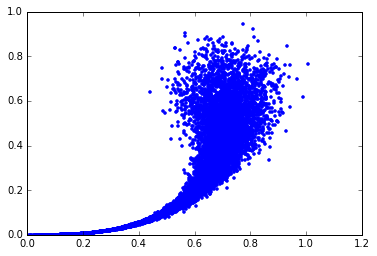

(9600, 2)

In [114]:
batch_size = 32

x_train = next_batch(batch_size*300)
plt.plot(x_train[:,0], x_train[:,1], '.')
plt.show()
x_train.shape

### Blog : building autoencoders in keras
https://blog.keras.io/building-autoencoders-in-keras.html

## Variational Auto-Encoder

In [97]:
original_dim = x_train.shape[1]

n_z = 1 #Dimension of the latent space
n_hidden_1 = 5
n_hidden_2 = 6

nb_epoch = 10
epsilon_std = 1.0

In [98]:
x = Input(batch_shape=(batch_size, original_dim))
h1 = Dense(n_hidden_1, activation='softplus')(x)
h2 = Dense(n_hidden_2, activation='softplus')(h1)
z_mean = Dense(n_z, activation=None)(h2)
z_log_var = Dense(n_z, activation=None)(h2)

assert(batch_size == 32) # WARNING : with 64 I get strange error messages
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, n_z), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(n_z,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h1 = Dense(n_hidden_1, activation='softplus')
decoder_h2 = Dense(n_hidden_2, activation='softplus')

h_decoded = decoder_h2(decoder_h1(z))

decoder_mean = Dense(original_dim, activation=None)
decoder_ls2 = Dense(original_dim, activation=None)

x_decoded_mean = decoder_mean(h_decoded)
x_decoded_ls2 = decoder_ls2(h_decoded)

#### Defining the loss function

##### The reconstruction error
We assume that the data x, is Gaussian distributed with diagnoal covariance matrix $\Sigma_{ij} = \delta_{i,j} \sigma_i^2$.

The parameters of that Gaussian are determined by the encoder network.

The reconstruction error for the $i-th$ example in the min-batch is given by 
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right)
$$
we approximate the expectation with sampling from the distribution (even with $L=1$)
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) \approx 
    \frac{1}{L} \sum_{i=1}^L \log\left(p(x^{(i)}|z^{(i,l)})\right) \approx \log\left(p(x^{(i)}|z^{(i,l)})\right)
$$

For the simple $J-dimensional$ Gaussian, we obtain the following reconstruction error (neglecting a constant term)
$$
    -\log\left(p(x^{(i)}|z^{(i)})\right) = \sum_{j=1}^D \frac{1}{2} \log(\sigma_{x_j}^2) + \frac{(x^{(i)}_j - \mu_{x_j})^2}{2 \sigma_{x_j}^2}
$$

##### The regularisation term

$$
    -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right) = \frac{1}{2} \sum_{j=1}^{J} \left(1 + \log(\sigma_{z_j}^{(i)^2}) - \mu_{z_j}^{(i)^2} - \sigma_{z_j}^{(i)^2} \right)
$$

In [99]:
# TensorFlow code for the loss function
#reconstr_loss = tf.reduce_sum(0.5 * x_ls2 + (tf.square(x-x_mu)/(2.0 * tf.exp(x_ls2))), 1)
#latent_loss = -0.5 * tf.reduce_sum(1 + z_ls2 - tf.square(z_mu) - tf.exp(z_ls2), 1)
#cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

#reconstr_loss = K.sum(0.5 * x_decoded_ls2 + (K.square(x-x_decoded_mean)/(2.0 * K.exp(x_decoded_ls2))), axis=-1)
#kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
def vae_loss(x, x_decoded_mean):
    #return K.sum(K.square(x_true - x_decoded_vec), axis=-1)
    #x_decoded_mean = x_decoded_vec
    #xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    reconstr_loss = K.sum(0.5 * x_decoded_ls2 + (K.square(x-x_decoded_mean)/(2.0 * K.exp(x_decoded_ls2))), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstr_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adadelta', loss=vae_loss)

In [103]:
#test_mdl = Model(x, z)
#vae.predict(x_train[0:32,:])

In [115]:
vae.fit(x_train[0:32*200], x_train[0:32*200],
        shuffle=True,
        nb_epoch=nb_epoch, # may have to increase this value, run 5x for ok-ish results
        batch_size=batch_size)
        #validation_data=(x_test, x_test))

Epoch 1/10
6400/6400 [==============================] - 0s - loss: -3.2421     
Epoch 2/10
6400/6400 [==============================] - 0s - loss: -3.2761     
Epoch 3/10
6400/6400 [==============================] - 0s - loss: -3.2745     
Epoch 4/10
6400/6400 [==============================] - 0s - loss: -3.2948     
Epoch 5/10
6400/6400 [==============================] - 0s - loss: -3.2974     
Epoch 6/10
6400/6400 [==============================] - 0s - loss: -3.3098     
Epoch 7/10
6400/6400 [==============================] - 0s - loss: -3.3112     
Epoch 8/10
6400/6400 [==============================] - 0s - loss: -3.3370     
Epoch 9/10
6400/6400 [==============================] - 0s - loss: -3.3498     
Epoch 10/10
6400/6400 [==============================] - 0s - loss: -3.3559     


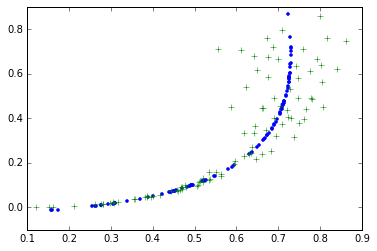

In [116]:
x_sample = next_batch(batch_size*3)
test_mdl = Model(x, x_decoded_mean)
x_mu_val = test_mdl.predict(x_sample)

plt.plot(x_mu_val[:,0], x_mu_val[:,1], '.')
plt.plot(x_sample[:,0], x_sample[:,1], '+')